# RNN

RNN model is a sort of network which considers the internal relationship of the inputs (mostly sequential). It is mostly applied in language precessing.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import glob, os, re, string, unicodedata, random

## Data Preparation

In [ ]:
# to download the dataset
!wget https://huggingface.co/datasets/Hobson/surname-nationality/resolve/main/surname-nationality.csv.gz?download=true

# using git to download, should install LFS

In [3]:
# data
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

def unicode_to_ascii(s, ALL_LETTERS):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data(ALL_LETTERS): # load locally stored data
    category_names = {}
    categories = []
    
    for file in glob.glob("./name_data/names/*.txt"):
        if file is not None:
            category = re.split('/|\.', file)[-2]
            categories.append(category)
            with open(file, "r") as f:
                category_names[category] = [unicode_to_ascii(l.split('\n')[0], ALL_LETTERS) for l in f]
                
    return category_names, categories

def letter2Tensor(l, ALL_LETTERS): # create one-hot of a letter
    ind = ALL_LETTERS.find(l)
    tensor = torch.tensor(1, len(ALL_LETTERS))
    tensor[ind] = 1
    return tensor

def word2Tensor(l, ALL_LETTERS): # create one-hot tensor for a word
    tensor = torch.zeros(len(l), 1, len(ALL_LETTERS))
    for i, letter in enumerate(l):
        ind = ALL_LETTERS.find(letter)
        tensor[i][0][ind] = 1
    return tensor

def RandomSample(category_names, categories): # randomly select one name in dataset

    def randomSelect(a):
        ind = random.randint(0, len(a)-1)
        return a[ind], ind

    categ, ind = randomSelect(categories)
    name, _ = randomSelect(category_names[categ])
    tensor_categ = torch.Tensor([ind]).type(torch.LongTensor)
    tensor_name = word2Tensor(name, ALL_LETTERS)
    return categ, name, tensor_categ, tensor_name

category_names, categories = load_data(ALL_LETTERS)
#print(category_names, categories)

In [11]:
categ, name, tensor_categ, tensor_name = RandomSample(category_names, categories)
print(name, tensor_name.size())
print(categ, tensor_categ)

Lemieux torch.Size([7, 1, 57])
French tensor([5])


In [10]:

n_categories = len(categories)
N_LETTERS = len(ALL_LETTERS)
print("all categories: ", categories)
print("number of categories: ", n_categories)
print("number of letters", N_LETTERS)

all categories:  ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
number of categories:  18
number of letters 57


## RNN model

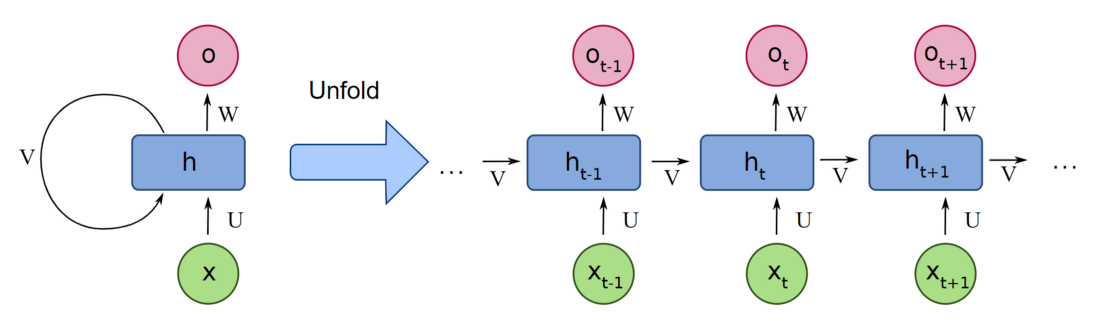

The model treat each word as a sequence of letters. Each letter in the randomly selected name is put into the model and the output is the category of the name.
This is the simplest model of RNN which uses only 2 linear layers in each bloc to produce an output and a hidden state.

In [11]:
# model

class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.linear1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.linear2 = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        combine = torch.cat((x, hidden), 1)
        out = self.linear2(combine)
        hidden = self.linear1(combine)
        out = self.softmax(out)
        return out, hidden
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

hidden_size = 128
model = RNN(N_LETTERS, hidden_size, n_categories)
loss_fn = nn.NLLLoss()
lr = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [8]:
def train(tensor_name, tensor_categ):
    hidden = model.init_hidden()
    for i in range(tensor_name.size()[0]):
        output, hidden = model(tensor_name[i], hidden)
    loss = loss_fn(output, tensor_categ)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss

In [20]:
# train loop

num_epochs = 100000
loss_tot = 0
accu_tot = 0
all_loss = []
all_accu = []
step = 5000

for e in range(num_epochs):
    model.train()
    categ, name, tensor_categ, tensor_name = RandomSample(category_names, categories)
    
    output, loss = train(tensor_name, tensor_categ)

    loss_tot += loss
    pred = out2Category(output)
    accu_tot += int(pred == categ)

    if (e + 1) % step == 0:
        all_loss.append(loss_tot / step) 
        all_accu.append(accu_tot / step)
        print(f"{e+1} / {num_epochs}: loss: {loss_tot / step}, accuracy: {accu_tot / step}, Truth: {categ}, Pred: {pred} ({pred == categ})")
        loss_tot = 0
        accu_tot = 0

    

5000 / 100000: loss: 1.2840917110443115, accuracy: 0.5898, Truth: Italian, Pred: Italian (True)
10000 / 100000: loss: 1.3007029294967651, accuracy: 0.5858, Truth: Russian, Pred: Russian (True)
15000 / 100000: loss: 1.2408363819122314, accuracy: 0.5992, Truth: Vietnamese, Pred: Vietnamese (True)
20000 / 100000: loss: 1.2594246864318848, accuracy: 0.6034, Truth: Portuguese, Pred: Czech (False)
25000 / 100000: loss: 1.2119807004928589, accuracy: 0.6168, Truth: German, Pred: Scottish (False)
30000 / 100000: loss: 1.257920742034912, accuracy: 0.5998, Truth: Italian, Pred: English (False)
35000 / 100000: loss: 1.231629729270935, accuracy: 0.6104, Truth: Korean, Pred: Korean (True)
40000 / 100000: loss: 1.2226382493972778, accuracy: 0.5996, Truth: Chinese, Pred: Chinese (True)
45000 / 100000: loss: 1.1831402778625488, accuracy: 0.6186, Truth: German, Pred: French (False)
50000 / 100000: loss: 1.2169309854507446, accuracy: 0.6128, Truth: Italian, Pred: Italian (True)
55000 / 100000: loss: 1.19

In [35]:
def out2Category(output):
    ind = torch.argmax(output)
    return categories[ind]
    
def predict(line):

    model.eval()

    with torch.no_grad():
        tensor = line2Tensor(line, ALL_LETTERS)
        hidden = model.init_hidden()
        for i in range(tensor.size()[0]):
            output, hidden = model(tensor[i], hidden)

    return out2Category(output)

In [21]:
print(predict("Gajos"))

Polish


## LSTM model using lstm layer

In [32]:
class LSTM (nn.Module) :

    def __init__(self, dim_input, dim_hidden, dim_output) :

        super().__init__()

        self.dim_input = dim_input
        self.dim_hidden = dim_hidden

        self.lstm_layer = nn.LSTM(dim_input, dim_hidden)
        self.linear = nn.Linear(dim_hidden, dim_output)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, cell) :

        out, (h, c) = self.lstm_layer(x, (hidden, cell))
        
        out = self.linear(out)
        out = self.softmax(out)
        return out, (h, c)


    def init_hidden(self):
        return torch.zeros(1, self.dim_hidden)

    def init_cell(self):
        return torch.zeros(1, self.dim_hidden)
        

In [34]:
def train(tensor_name, tensor_categ):
    hidden = lstm.init_hidden()
    cell = lstm.init_cell()
    for i in range(tensor_name.size()[0]):
        #print(tensor_name[i])
        output, (hidden, cell) = lstm(tensor_name[i], hidden, cell)
    loss = loss_fn(output, tensor_categ)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss

In [37]:
if False:
    dim_hidden = 128
    lstm = LSTM(N_LETTERS, dim_hidden, n_categories)
    loss_fn = nn.NLLLoss()
    
    optimizer = torch.optim.SGD(lstm.parameters(), lr = lr)
    
    
    loss_tot = 0
    accu_tot = 0
    all_loss = []
    all_accu = []
    step = 5000
num_epochs = 100000  
lr = 0.01
for e in range(num_epochs):
    lstm.train()
    categ, name, tensor_categ, tensor_name = RandomSample(category_names, categories)
    
    output, loss = train(tensor_name, tensor_categ)

    loss_tot += loss
    pred = out2Category(output)
    accu_tot += int(pred == categ)

    if (e + 1) % step == 0:
        all_loss.append(loss_tot / step) 
        all_accu.append(accu_tot / step)
        print(f"{e+1} / {num_epochs}: loss: {loss_tot / step}, accuracy: {accu_tot / step}, Truth: {categ}, Pred: {pred} ({pred == categ})")
        loss_tot = 0
        accu_tot = 0

5000 / 100000: loss: 1.3753793239593506, accuracy: 0.5436, Truth: French, Pred: Portuguese (False)
10000 / 100000: loss: 1.358773112297058, accuracy: 0.5496, Truth: Japanese, Pred: Japanese (True)
15000 / 100000: loss: 1.3125141859054565, accuracy: 0.5656, Truth: Polish, Pred: Japanese (False)
20000 / 100000: loss: 1.2775144577026367, accuracy: 0.5776, Truth: Vietnamese, Pred: Vietnamese (True)
25000 / 100000: loss: 1.2363402843475342, accuracy: 0.594, Truth: Irish, Pred: Irish (True)
30000 / 100000: loss: 1.2481210231781006, accuracy: 0.5904, Truth: French, Pred: French (True)
35000 / 100000: loss: 1.223466396331787, accuracy: 0.591, Truth: German, Pred: German (True)
40000 / 100000: loss: 1.1915892362594604, accuracy: 0.611, Truth: Polish, Pred: Polish (True)
45000 / 100000: loss: 1.1646884679794312, accuracy: 0.6174, Truth: German, Pred: Scottish (False)
50000 / 100000: loss: 1.1416903734207153, accuracy: 0.619, Truth: Italian, Pred: Japanese (False)
55000 / 100000: loss: 1.11799836

Those networks are applied mostly on language processing (OCR, sentimental analysis, translation...). The disadvantage of those networks is it is long to train since the data should be input to the model sequentially.

References:
 * http://colah.github.io/posts/2015-08-Understanding-LSTMs/
 * https://d2l.ai/chapter_recurrent-modern/lstm.html